# Multiple Linear Regression - Underfitting and Overfitting

Polynomial regression is the process of fitting a polynomial of order n to a data set. If n=1 this corresponds to the linear regression that has already been investigated.

In this lesson we will investigate how polynomial regression can be implemented using `sklearn`. In particular, we will discuss the problems of of underfitting and overfitting data, and how overfitting can be addressed using the `Ridge` and `Lasso` regularization techniques.

Initially, we import some standard libraries that we are going to need.

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

import warnings

warnings.filterwarnings('ignore')

We define a function that we will use to fit the polynomials to.

In [35]:
def cos_fun(X):
    return np.cos(.15*np.pi*X) #true model

Finally, we define a training set `x` and `y`, and a testing set `x_test` and `y_test`. Both of these have a small amount of noise added to the function.

In [36]:
rng = np.random.RandomState(1) #setting rng state for uniform distribution
nsamp = 30
x = 10*rng.rand(nsamp)
y = cos_fun(x)+.1*rng.randn(nsamp) #observed data from true model (true model with noise)
x_test = 10*rng.rand(nsamp)
y_test = cos_fun(x_test)+.1*rng.randn(nsamp)

## Contents 

* Numpy Polynomial Fitting
* ScikitLearn Polynomial Regression
* Ridge and Lasso Regularization
* Exercises

## Numpy polynomial fitting 

The easiest way to fit a polynomial our data set is using the numpy routine `polyfit`. This minimizes the least squares error, the same as for linear regression. `polyfit` calculates the coefficients of the polynomial of degree n, starting from the highest coefficient and descending to the constant term. The routine `poly1d` takes the coefficients of a polynomial, as given by `polyfit`, and generates a one-dimensional polynomial function. 

Here we calculate these polynomials for degrees 0, 1, 4 and 15.

In [37]:
p0 = np.poly1d(np.polyfit(x, y, 0))
p1 = np.poly1d(np.polyfit(x, y, 1))
p4 = np.poly1d(np.polyfit(x, y, 4))
p15 = np.poly1d(np.polyfit(x, y, 15))

We now plot these polynomials against the training set and the true function.

The zeroth and first order polynomials (constant and linear functions) can be seen to be underfitted, due to the fact that there is insufficient complexity in the model. Such models are said to have high *bias* and low *variance*. For any randomly selected training set on this interval they will give very similar results. 

Bias is error from erroneous assumptions in the model. High bias can cause the model to miss the relevant relations between features and target outputs (underfitting). Variance is a error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (overfitting).

The fifteenth order polynomial suffers from overfitting. The polynomial passes through most of the points in the training set, but in the intervals between these points there are very large variations. For another randomly selected training set the results would be noticeably different. Consequently the model is said to have high *variance*. This can be addressed by reducing the complexity of the model, or increasing the size of the training set.

The quartic can be seen to perform very well, and balances *bias* and *variance*. It is apparent that this model has optimal complexity for the data set. However, how do we pick the optimal complexity for our model? This is where machine learning comes in. Here we will show how this can be achieved using regularization.

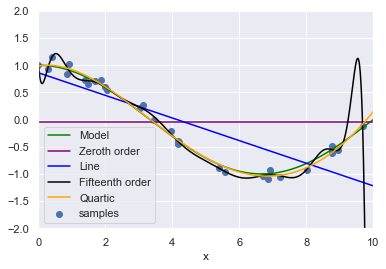

In [38]:
xfit = np.linspace(0,10,1000)                  
plt.plot(xfit,cos_fun(xfit),label="Model",color='green')
plt.scatter(x,y,label="samples")                #observed data
plt.plot(xfit,p0(xfit),label="Zeroth order",color='purple')    #mean of y
plt.plot(xfit,p1(xfit),label="Line",color='blue')
plt.plot(xfit,p15(xfit),label="Fifteenth order",color='black')
plt.plot(xfit,p4(xfit),label="Quartic",color='orange')
plt.legend(loc="best")
plt.xlabel('x')
plt.xlim((0,10))
plt.ylim((-2,2));

To illustrate the overfitting of the fifteenth order polynomial, we can plot the same results against the testing set. In this case the lower order polynomials are coincide reasonably with the data points, however the fifteenth order polynomial no longer provides an accurate model for the data.

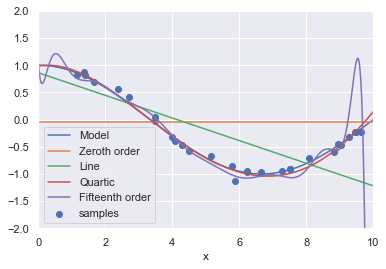

In [40]:
xfit = np.linspace(0,10,1000)
plt.plot(xfit,cos_fun(xfit),label="Model")
plt.scatter(x_test,y_test,label="samples")
plt.plot(xfit,p0(xfit),label="Zeroth order")
plt.plot(xfit,p1(xfit),label="Line")
plt.plot(xfit,p4(xfit),label="Quartic")
plt.plot(xfit,p15(xfit),label="Fifteenth order")
plt.legend(loc="best")
plt.xlabel('x')
plt.xlim((0,10))
plt.ylim((-2,2));

We can calculate the accuracy of each of the polynomial models, by calculating the square of the correlation coefficient ($R^2$) for the actual target values and predicted values. Recall that the training accuracy is the calculation for data points used to create the model, while the testing accuracy is the calculation for data points not seen by the model. Note that we can't calculate accuracy for p0 since the standard deviation of the model values is zero.

As expected, the training accuracy increases as the polynomial order increases.

In [41]:
a1 = np.corrcoef(p1(x),y)
a4 = np.corrcoef(p4(x),y)
a15 = np.corrcoef(p15(x),y)

print("Training accuracy: Linear - %4.3f, Quartic - %4.3f, 15th order - %4.3f" 
      % (a1[0,1]**2, a4[0,1]**2, a15[0,1]**2))

Training accuracy: Linear - 0.723, Quartic - 0.989, 15th order - 0.995


However, the testing accuracy is a maximum for the quartic and decreases dramatically for the fifteenth order polynomial. This is due to overfitting and sensitivity of the model to the chosen data points.

In [42]:
a1 = np.corrcoef(p1(x_test),y_test)
a4 = np.corrcoef(p4(x_test),y_test)
a15 = np.corrcoef(p15(x_test),y_test)

print("Testing accuracy: Linear - %4.3f, Quartic - %4.3f, 15th order - %4.3f" 
      % (a1[0,1]**2, a4[0,1]**2, a15[0,1]**2))

Testing accuracy: Linear - 0.433, Quartic - 0.985, 15th order - 0.755


## ScikitLearn Polynomial Regression  

Now we perform polynomial regression using `sklearn`. Previously we saw how to do this with the Diabetes dataset. Here we will again show how to undertake multiple linear regression, but in this case, applied to fitting polynomials to our data.

We also introduce a function to calculate $R^2$. Recall that this lies between 0 and 1, and for the best models, this will be close to 1.

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

To implement linear regression, we instatiate the model and fit our training data set `x` and `y`. This will give a slope and intercept for the line of best fit, and we can then find the predicted values for this model, `y_pred`, for our values `x_test`. The success of the model can be found be comparing the predicted values with the actual values for the test set, `y_test`. `np.newaxis` allows us to convert a vector to a matrix with one column.

In [44]:
rng = np.random.RandomState(1)
model = LinearRegression(fit_intercept=True)
model.fit(x[:,np.newaxis],y)
print("Model slope:  %5.3f  " % model.coef_[0])
print("Model intercept: %5.3f" % model.intercept_)

Model slope:  -0.208  
Model intercept: 0.861


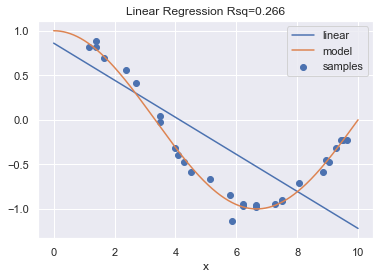

In [45]:
yfit = model.predict(xfit[:,np.newaxis])         #y values from the model (for plotting)
y_pred = model.predict(x_test[:,np.newaxis])     #predicted y values from the test set
rsquared_linear = r2_score(y_pred,y_test)        #r2 on test set (testing score)
plt.scatter(x_test,y_test, label='samples')                #plotting training data
plt.plot(xfit,yfit, label='linear')              #plotting regression line (alternative to sns.regplot)
plt.plot(xfit,cos_fun(xfit), label='model')      #plotting true model
plt.legend()
plt.xlabel('x')
plt.title("Linear Regression Rsq=%4.3f" % (rsquared_linear));

To undertake polynomial regression is a bit more complex. 

First we need to define a Vandermonde matrix. Assume we have a vector of x values given by `[x1,x2,...,xn]`, then the entry in row `i` and column `j` of the Vandermonde matrix will be `(xi)**(m-(j-1))`, where the two asterisks denote exponentiation. Therefore the first row will be `[(x1)**m,(x1)**(m-1), ...,x1,1]`. Hence the Vandermonde matrix has `n` data points and `m+1` features for each data point. Since the last column only has ones, it actually only has `m` independent features. Note that the argument we pass to `vander` is the number of columns of the matrix, which is one more than the order of the polynomial. A simple example of a Vandermonde matrix of order 3 is shown below.

In [46]:
z = [0,1,2,3]
Z = np.vander(z, 4)
print(Z)

[[ 0  0  0  1]
 [ 1  1  1  1]
 [ 8  4  2  1]
 [27  9  3  1]]


Here our order of the polynomial is `reg_ord=4`, i.e., a quartic.

The Vandermonde matrix can now be passed to our linear regression model to perform multiple linear regression. Previously we did this to perform linear regression in multiple dimensions. Here we are doing a similar thing, but performing in multiple independent functions, where the functions are `x**m`, `x**(m-1)`, ..., `x`.

Once we have the coefficients of the model, we can use the model in the same way to give predicted values for our testing set, and compare them against the actual target values for the training set.

Note that we could also perform polynomial regression using the sklearn routines `PolynomialFeatures` and `make_pipeline`. This is a bit more compact, but the process used here provides a better understanding of polynomial regression.

Here we see that accuracy is very close to 1, which shows that a quartic is a very good model for this data.


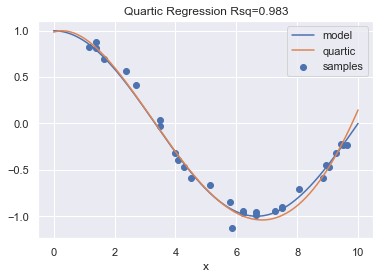

In [47]:
rng = np.random.RandomState(1)
reg_ord = 4
model = LinearRegression(fit_intercept=True)        #set up regression
model.fit(np.vander(x,reg_ord+1),y)                 #fit poly model 
yfit = model.predict(np.vander(xfit,reg_ord+1))     #get model predictions for plotting
y_pred = model.predict(np.vander(x_test,reg_ord+1)) #get model predictions on test data 
rsquared_quartic = r2_score(y_test,y_pred)          #get r2 on test set
plt.scatter(x_test,y_test, label='samples')
plt.plot(xfit,cos_fun(xfit), label='model')
plt.plot(xfit,yfit, label='quartic')                 #plot regression line                       
plt.legend()
plt.xlabel('x')
plt.title("Quartic Regression Rsq=%5.3f" % (rsquared_quartic));

We can view the coefficients and intercept of the model. We don't show the last coefficient as this is 0. 

In [48]:
print("Model coefficients:  ", np.round(model.coef_[0:-1],3))
print("Model intercept:   %5.3f    " % model.intercept_)

quadcoefs = np.log10(abs(model.coef_[0:reg_ord])) #for later example

Model coefficients:   [-0.001  0.025 -0.194  0.103]
Model intercept:   0.985    


We can repeat the process for a fifteenth order polynomial by only changing `reg_ord`. In this case the correlation coefficient decreases significantly, due the overfitting by the model.

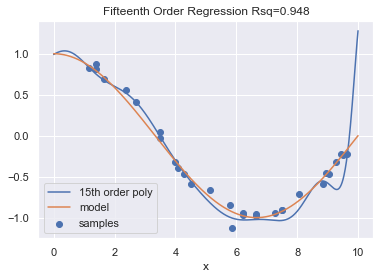

In [49]:
rng = np.random.RandomState(1)
reg_ord = 15;
model = LinearRegression(fit_intercept=True)
model.fit(np.vander(x,reg_ord+1),y)
yfit = model.predict(np.vander(xfit,reg_ord+1))
y_pred = model.predict(np.vander(x_test,reg_ord+1))
rsquared = r2_score(y_test,y_pred)
plt.scatter(x_test,y_test, label='samples')
plt.plot(xfit,yfit, label='15th order poly')
plt.plot(xfit,cos_fun(xfit), label='model')
plt.legend()
plt.xlabel('x')
plt.title("Fifteenth Order Regression Rsq=%5.3f" % (rsquared));

If we print the coefficients, it is apparent they dramatically decrease in magnitude for the higher order terms.

In [50]:
print("Model coefficients:    ", model.coef_[0:-1])
print("Model intercept:   ", model.intercept_)
lincoefs = np.log10(abs(model.coef_[0:reg_ord]));

Model coefficients:     [-4.14069410e-09  2.67243945e-07 -7.59025066e-06  1.24484885e-04
 -1.29856430e-03  8.92203140e-03 -4.01965604e-02  1.12765770e-01
 -1.66680480e-01  3.98261462e-02  1.73205732e-01 -7.16871301e-03
 -2.30528069e-01 -2.13933588e-01  2.26906301e-01]
Model intercept:    0.9905320987616388


Although the coefficients are decreasing dramatically in magnitude, it is not sufficiently rapidly to overcome overfittting. For the fifteenth order polynomial above recall that the largest value of `x` is 10, so the magnitude of the largest term in the polynomial is $10^{-9}\times 10^{15} = 10^6$. Compare this with the magnitude of the constant and linear terms, which are $0.991$ and $2.27$ respectively.

One way to determine the optimal polynomial order is to calculate the training and testing scores as a function of order. The optimal order will then be that with the maximum testing score. The training score keeps increasing, but testing score peaks at about order=6 and then decreases due to overfitting. This is where the combination of errors due to bias and variance are minimized.

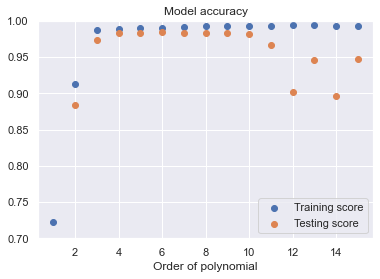

In [51]:
training = np.zeros(15)
testing = np.zeros(15)
for ord in range(1,16):
    rng = np.random.RandomState(1)
    reg_ord = ord;
    model = LinearRegression(fit_intercept=True).fit(np.vander(x,reg_ord+1),y)
    training[ord-1] = model.score(np.vander(x,reg_ord+1),y)
    y_pred = model.predict(np.vander(x_test,reg_ord+1))
    testing[ord-1] = r2_score(y_test,y_pred)

plt.scatter(range(1,16), training, label='Training score')
plt.scatter(range(1,16), testing, label='Testing score')
plt.legend()
plt.xlabel('Order of polynomial')
plt.ylim((.7, 1.))
plt.title('Model accuracy');

## Ridge and Lasso Regularization

In general there may not be a parameter such as polynomial order which can be minimized. In these circumstances we can use regularization to reduce the variance of models. Regularization aims to reduce the magnitude of these coefficents by modifying the function that is minimized.

The main two forms of regularization are Ridge and Lasso regularization, which are implemented in the `sklearn` functions of the same name.

In [52]:
from sklearn.linear_model import Ridge, Lasso

Ridge regularization adds the term $\alpha(\theta_1^2+\theta_2^2+...+\theta_m^2)$, where in this case $\theta_1, \theta_2, \dots, \theta_m$ are the coefficients of the polynomial, to the sum of the square of the errors. This penalty can be solved for in a similar time as for linear regression.

Using the value of $\alpha =2$, it is apparent visually and from the correlation coefficient that this improves the fit of the polynomial.

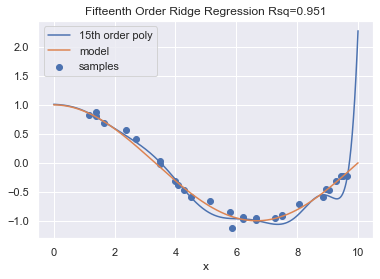

In [53]:
rng = np.random.RandomState(1)
reg_ord = 15;
model = Ridge(alpha=2., fit_intercept=True)   #use ridge regression
model.fit(np.vander(x,reg_ord+1),y)
yfit = model.predict(np.vander(xfit,reg_ord+1))
y_pred = model.predict(np.vander(x_test,reg_ord+1))
rsquared = r2_score(y_test,y_pred)
ridgecoefs = np.log10(abs(model.coef_[0:reg_ord])); #for later plotting
plt.scatter(x_test,y_test, label='samples')
plt.plot(xfit,yfit, label='15th order poly')
plt.plot(xfit,cos_fun(xfit), label='model')
plt.legend()
plt.xlabel('x')
plt.title("Fifteenth Order Ridge Regression Rsq=%5.3f" % (rsquared));

Lasso regularization adds the term  $\alpha(\left|\theta_1\right|+\left|\theta_2\right|+\cdots+\left|\theta_m\right|)$, to the sum of the square of the errors. This penalty has a more marked effect on the coefficients than Ridge regularization, but takes longer to solve for. Using the value of $\alpha = 0.1$, we obtain an even more accurate model.

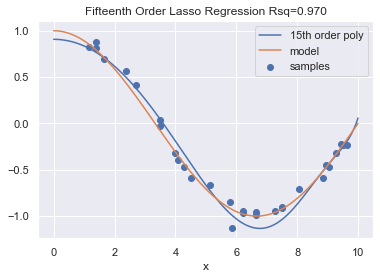

In [54]:
rng = np.random.RandomState(1)
reg_ord = 15;
model = Lasso(alpha=.1,fit_intercept=True)      #implement lasso regression
model.fit(np.vander(x,reg_ord+1),y)
yfit = model.predict(np.vander(xfit,reg_ord+1))
y_pred = model.predict(np.vander(x_test,reg_ord+1))
rsquared = r2_score(y_test,y_pred)
lassocoefs = np.log10(abs(model.coef_[0:reg_ord]));  #for later plotting

plt.scatter(x_test,y_test, label='samples')
plt.plot(xfit,yfit, label='15th order poly')
plt.plot(xfit,cos_fun(xfit), label='model')
plt.legend()
plt.xlabel('x')
plt.title("Fifteenth Order Lasso Regression Rsq=%5.3f" % (rsquared));

Finally, we can investigate how rapidly the coefficients decay with order for the linear regression and regularization models. For ridge regularization the the higher order coefficients are an order of magnitude smaller, while for lasso regularization the higher order coefficients are approximately six orders of magnitude smaller. This regularization acts to suppress overfitting.

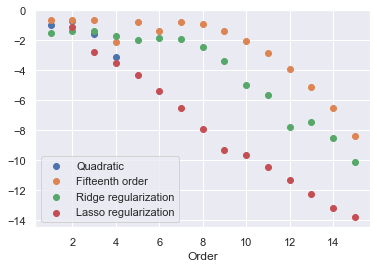

In [55]:
plt.scatter(np.arange(1,5), quadcoefs[::-1], label='Quadratic')
plt.scatter(np.arange(1,16), lincoefs[::-1], label='Fifteenth order')
plt.scatter(np.arange(1,16), ridgecoefs[::-1], label='Ridge regularization')
plt.scatter(np.arange(1,16), lassocoefs[::-1], label='Lasso regularization')
plt.xlabel('Order')
plt.legend()

## Exercises 

In these exercises we will use attempt to model the following function which is related to the [Witch of Agnesi](https://mathworld.wolfram.com/WitchofAgnesi.html).

In [185]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [186]:
def witch(X):
    return 4*X/(X**2+4)

Use the following variables for the testing and training sets.

In [187]:
rng1 = np.random.RandomState(0)
nsamp1 = 30
noise1 = .2;
x1 = 20*rng1.rand(nsamp1)-10
y1 = witch(x1)+noise1*rng1.randn(nsamp1)
x_test1 = 20*rng1.rand(nsamp1)-10
y_test1 = witch(x_test1)+noise1*rng1.randn(nsamp1)

In [171]:
#p01 = np.poly1d(np.polyfit(x1, y1, 0))
#p11 = np.poly1d(np.polyfit(x1, y1, 1))
#p41 = np.poly1d(np.polyfit(x1, y1, 4))
#p151 = np.poly1d(np.polyfit(x1, y1, 15))

### Exercise 1 

Use `np.linspace()` to create an x array over the interval (-10,10), and plot the witch function against scatter plots of the testing and training sets. (2 marks)

In [188]:

model1 = LinearRegression(fit_intercept=True)
model1.fit(x1[:,np.newaxis],y1)
print("Model slope:  %5.3f  " % model1.coef_[0])
print("Model intercept: %5.3f" % model1.intercept_)

Model slope:  0.073  
Model intercept: 0.060


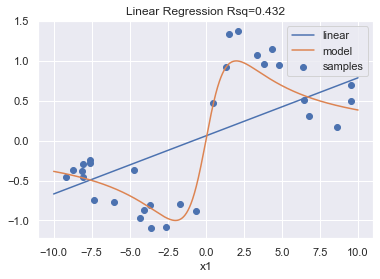

In [189]:
xfit1 = np.linspace(-10,10,1000)
yfit1 = model1.predict(xfit1[:,np.newaxis])         #y values from the model (for plotting)
y_pred1 = model1.predict(x_test1[:,np.newaxis])     #predicted y values from the test set
rsquared_linear1 = r2_score(y_test1,y_pred1)        #r2 on test set (testing score)
plt.scatter(x_test1,y_test1, label='samples')                #plotting training data
plt.plot(xfit1,yfit1, label='linear')              #plotting regression line (alternative to sns.regplot)
plt.plot(xfit1,witch(xfit1), label='model')      #plotting true model
plt.legend()
plt.xlabel('x1')
plt.title("Linear Regression Rsq=%4.3f" % (rsquared_linear1));

## Exercise 2

Use the `sklearn` Linear Regression model to fit a ninth order polynomial to the training set. Calculate the training and testing accuracies. (3 marks)

Text(0.5, 1.0, 'Nineth Order Regression Rsq=0.882')

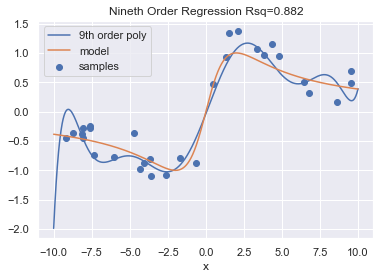

In [190]:
rng = np.random.RandomState(1)
reg_ord = 9;
model3 = LinearRegression(fit_intercept=True)
model3.fit(np.vander(x1,reg_ord+1),y1)
yfit3 = model3.predict(np.vander(xfit1,reg_ord+1))
y_pred3 = model3.predict(np.vander(x_test1,reg_ord+1))
rsquared3 = r2_score(y_test1,y_pred3)
plt.scatter(x_test1,y_test1, label='samples')
plt.plot(xfit1,yfit3, label='9th order poly')
plt.plot(xfit1,witch(xfit1), label='model')
plt.legend()
plt.xlabel('x')
plt.title("Nineth Order Regression Rsq=%5.3f" % (rsquared3))

In [183]:
p9=np.poly1d(np.polyfit(x1, y1, 9))
a9=np.corrcoef(p9(x1),y1)

print("Training accuracy:9th order - %4.3f" 
      %  a9[0,1]**2)

Training accuracy:9th order - 0.920


In [184]:
a9 = np.corrcoef(p9(x_test1),y_test1)

print("Testing accuracy: 15th order - %4.3f" 
      %  a9[0,1]**2)

Testing accuracy: 15th order - 0.891


## Exercise 3

Use the `sklearn` Ridge Regularization model with `alpha=0.5` to again fit a ninth order polynomial to the training set. Calculate the training and testing accuracies. (3 marks)

In [174]:
from sklearn.linear_model import Ridge, Lasso

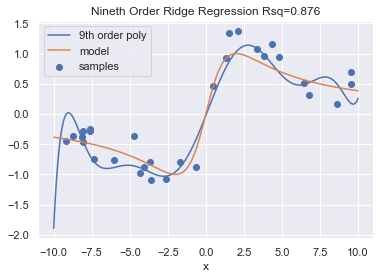

In [177]:
rng = np.random.RandomState(1)
reg_ord =9;
model2= Ridge(alpha=0.5, fit_intercept=True)   
model2.fit(np.vander(x1,reg_ord+1),y1)
yfit2 = model2.predict(np.vander(xfit1,reg_ord+1))
y_pred2 = model2.predict(np.vander(x_test1,reg_ord+1))
rsquared2 = r2_score(y_test1,y_pred2)
ridgecoefs1 = np.log10(abs(model2.coef_[0:reg_ord]));
plt.scatter(x_test1,y_test1, label='samples')
plt.plot(xfit1,yfit2, label='9th order poly')
plt.plot(xfit1,witch(xfit1), label='model')
plt.legend()
plt.xlabel('x')
plt.title("Nineth Order Ridge Regression Rsq=%5.3f" % (rsquared2));

In [178]:
p9=np.poly1d(np.polyfit(x1, y1, 9))
a9=np.corrcoef(p9(x1),y1)

print("Training accuracy:9th order - %4.3f" 
      %  a9[0,1]**2)

Training accuracy:9th order - 0.920


In [179]:
a9 = np.corrcoef(p9(x_test1),y_test1)

print("Testing accuracy: 15th order - %4.3f" 
      %  a9[0,1]**2)

Testing accuracy: 15th order - 0.891


## Exercise 4

Plot the models against the witch function and the training set. (2 marks)

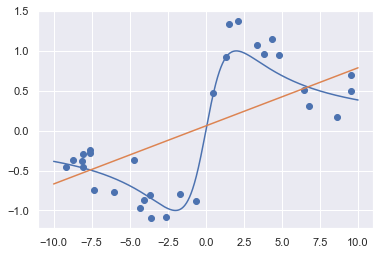

In [193]:
plt.scatter(x_test1,y_test1, label='samples')  
plt.plot(xfit1,witch(xfit1), label='model')
plt.plot(xfit1,yfit1, label='linear') 